In [ ]:
import itertools
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter(action = 'ignore', category= FutureWarning)

# general settings

In [17]:
# general settings
class CFG:
    data_folder = 'data_science/datasets/raw/'
filepath = '/Users/q/Projects/data_science/datasets/raw/ambient_temperature_system_failure.csv'



               timestamp      value
0    2014-01-03 07:00:00  73.577696
1    2014-01-03 08:00:00  73.392900
2    2014-01-03 09:00:00  73.400300
3    2014-01-03 10:00:00  73.157027
4    2014-01-03 11:00:00  73.148395
...                  ...        ...
3266 2014-05-28 11:00:00  72.370206
3267 2014-05-28 12:00:00  72.172956
3268 2014-05-28 13:00:00  72.046565
3269 2014-05-28 14:00:00  71.825226
3270 2014-05-28 15:00:00  72.584089

[3271 rows x 2 columns]


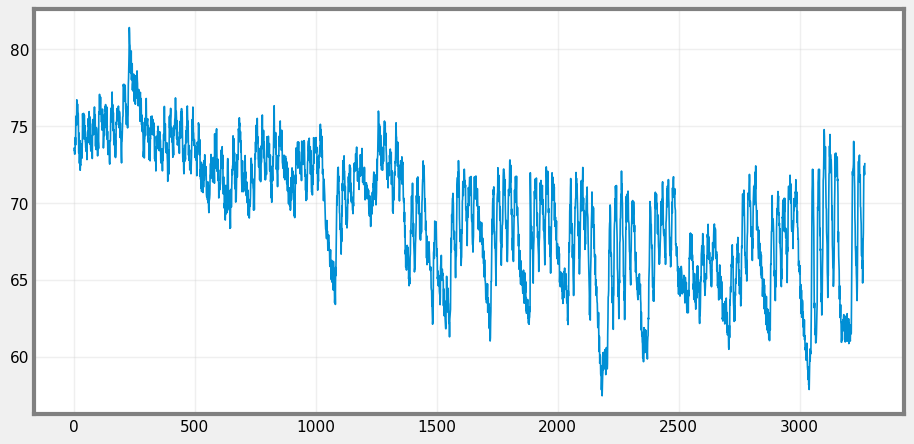

In [67]:
# load 
series = pd.read_csv(filepath)
series['timestamp'] = pd.to_datetime(series['timestamp'])

#plot
series['value'].plot()


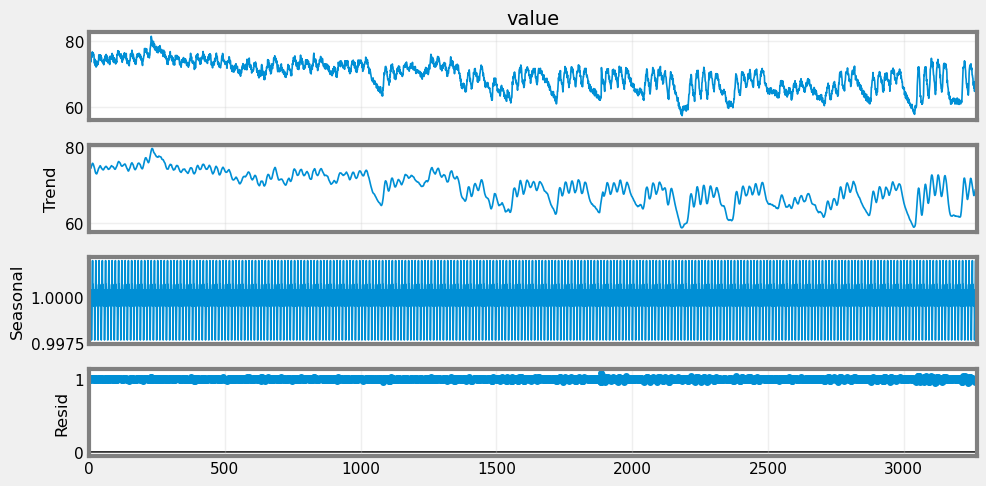

In [70]:
decomposition = sm.tsa.seasonal_decompose(series['value'], period=12,model='multiplicative')
figure = decomposition.plot()
plt.show()

<Axes: >

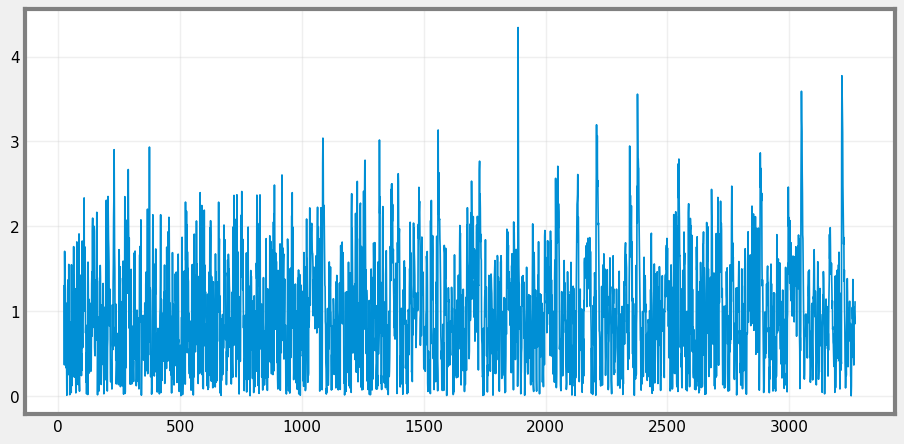

In [25]:
window_size = 25

xroll = series['value'].rolling(window_size)
series['mean_roll'] =xroll.mean()
series['sd_roll'] = xroll.std()

series['zscore'] = np.abs((series['value'] -series['mean_roll'])/series['sd_roll'])
series['zscore'].plot()

In [29]:
series.loc[series['zscore'] > 3][['timestamp', 'value']]

,timestamp,value
1086,2014-02-17 13:00:00,69.519207
1318,2014-02-27 05:00:00,69.425502
1559,2014-03-10 11:00:00,67.688348
1887,2014-03-24 19:00:00,71.943363
2209,2014-04-14 10:00:00,63.873030
2212,2014-04-14 13:00:00,66.890486
2377,2014-04-21 10:00:00,64.916813
2378,2014-04-21 11:00:00,65.396986
3050,2014-05-19 11:00:00,66.461085
3051,2014-05-19 12:00:00,68.261759


<Axes: xlabel='date'>

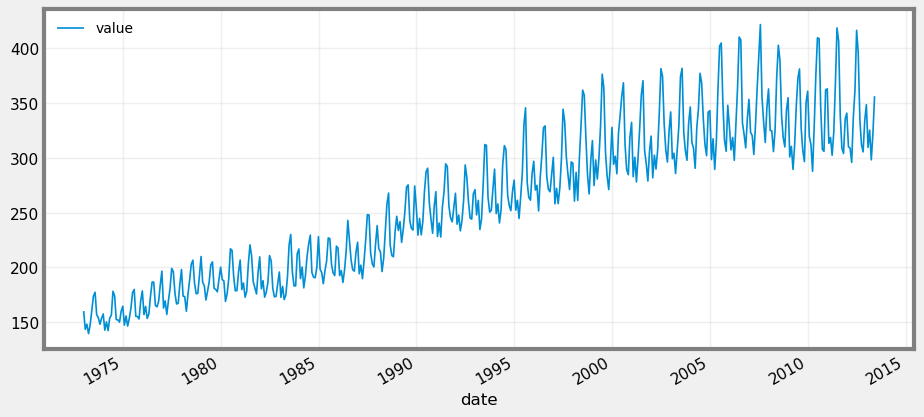

In [32]:
file_path = '/Users/q/Projects/data_science/datasets/raw/us_energy.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()



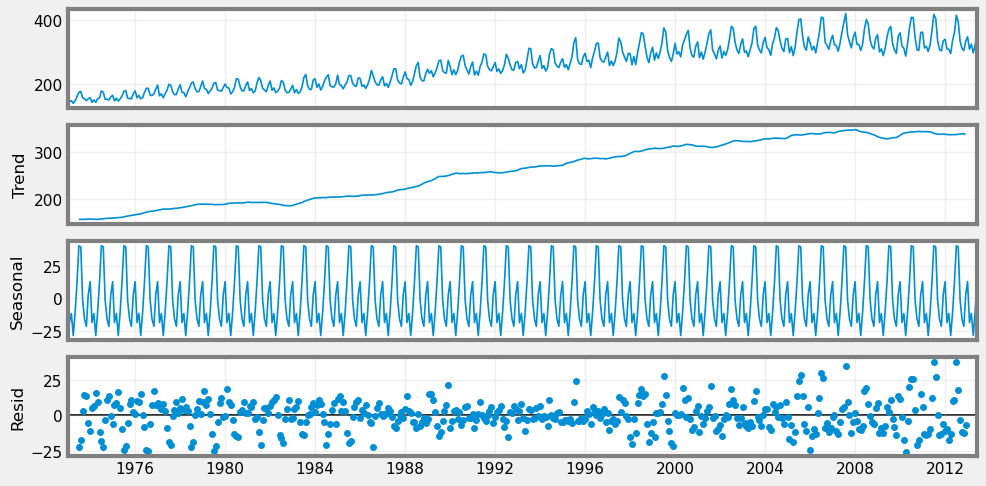

In [36]:
# perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df, period = 12)
figure = decomposition.plot()
plt.show()

In [38]:
cutoff_date = '2005-12-31'
xtrain, xvalid = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)


(397, 1) (89, 1)


In [63]:
fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 =fit1.fit()
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.281723,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.226282,True
initial_level,l.0,155.198930,True
initial_trend,b.0,1.001948,True
initial_seasons.0,s.0,1.044370,True
initial_seasons.1,s.1,0.920101,True
initial_seasons.2,s.2,0.944794,True
initial_seasons.3,s.3,0.878052,True
initial_seasons.4,s.4,0.927204,True


AttributeError: 'HoltWintersResults' object has no attribute 'plottedvalues'

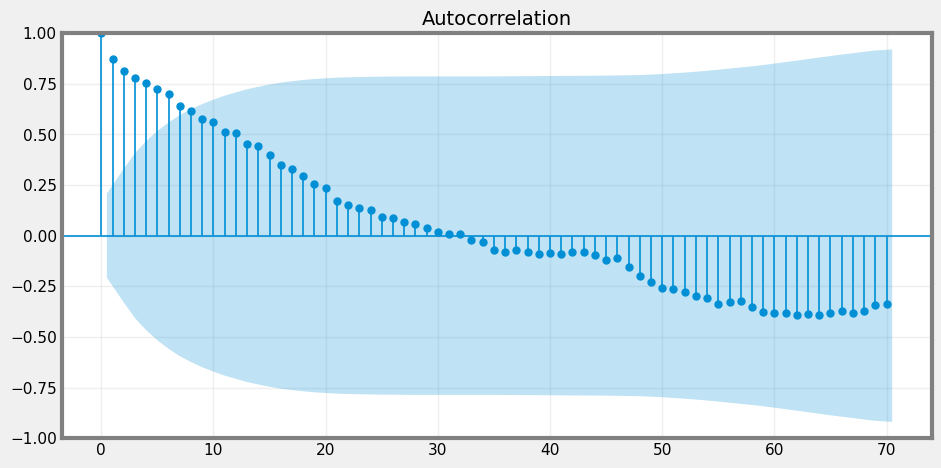

In [59]:
prediction = fit1.forecast(len(xvalid)).copy()
xresiduals = xvalid['value'] - prediction
plot_acf(xresiduals, lags = 70)
print()

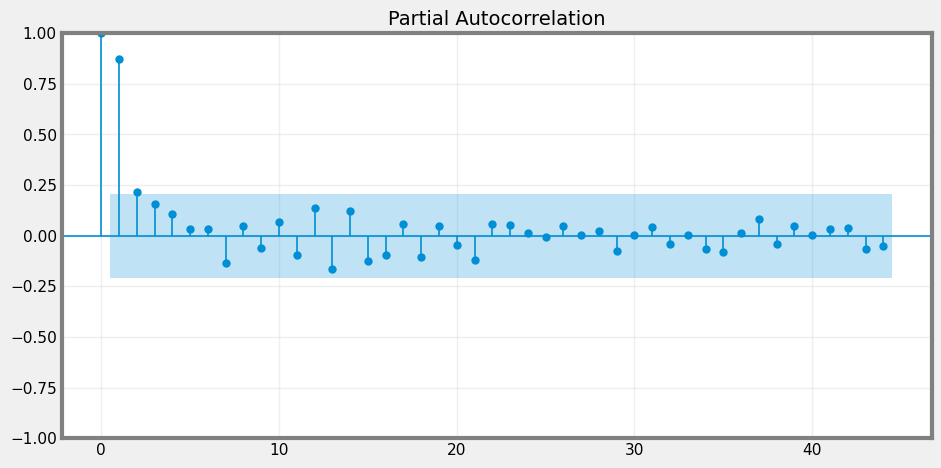

In [61]:
plot_pacf(xresiduals, lags = 44)
print()

/var/folders/g0/5s73wq9x27b9qwvrczncd0hc0000gn/T/ipykernel_8153/4205454841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalid['prediction'] = prediction


<Axes: xlabel='date'>

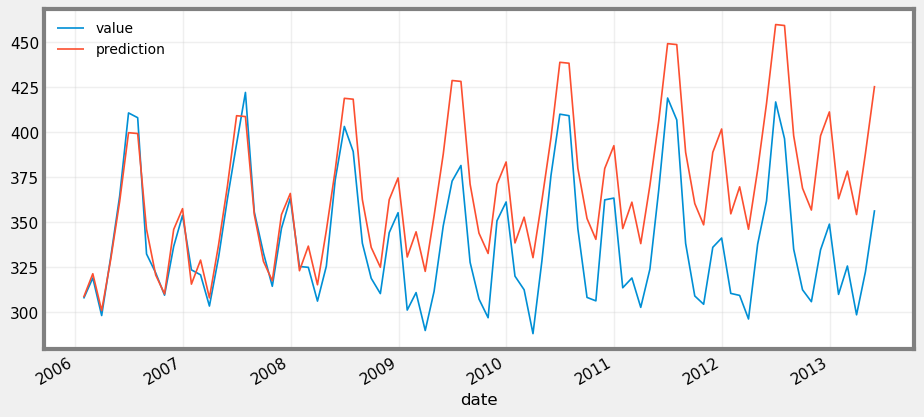

In [71]:
xvalid['prediction'] = prediction
xvalid.plot()